#Table of Contents
* [Homework 0](#Homework-0)
    * [Import](#Import)
	* [Functions Definitions](#Functions Definitions)
		* [1. generate_tp_and_fp_vcfs](#1.-generate_tp_and_fp_vcfs)
		* [2. qual](#2.-qual)
		* [3. count_freq](#3.-count_freq)
		* [4. count_homopolymers](#4.-count_homopolymers)
	* [Features Analysis](#Features Analysis)
		* [1. Quality](#1.-Quality)
		* [2. Count homopolymers](#2.-Count homopolymers)
		* [3. Count nucleotydes](#3.-Count nucleotydes)

### Import

In [ ]:
import plotly
import pysam 
import math
import vcf as pyvcf
from pyfasta import Fasta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, integrate
import seaborn as sns

Инициализация путей и словаря для доступа к записям референса

In [13]:
our_vcf = '/home/alexgri/indels/gcat_set_059-ensemble.vcf'
our_short_vcf = '/home/alexgri/indels/gcat_set_059-ensemble_head.vcf'
true_vcf = '/home/alexgri/indels/NA12878.vcf'
tp_vcf = '/home/alexgri/indels/gcat_set_059-ensemble_tp.vcf'
fp_vcf = '/home/alexgri/indels/gcat_set_059-ensemble_fp.vcf'
reference = '/home/alexgri/indels/human_g1k_v37.fasta'
chr_dict = {'1':'1 dna:chromosome chromosome:GRCh37:1:1:249250621:1',
            '2':'2 dna:chromosome chromosome:GRCh37:2:1:243199373:1',
            '3':'3 dna:chromosome chromosome:GRCh37:3:1:198022430:1',
            '4':'4 dna:chromosome chromosome:GRCh37:4:1:191154276:1',
            '5':'5 dna:chromosome chromosome:GRCh37:5:1:180915260:1',
            '6':'6 dna:chromosome chromosome:GRCh37:6:1:171115067:1',
            '7':'7 dna:chromosome chromosome:GRCh37:7:1:159138663:1',
            '8':'8 dna:chromosome chromosome:GRCh37:8:1:146364022:1',
            '9':'9 dna:chromosome chromosome:GRCh37:9:1:141213431:1',
            '10':'10 dna:chromosome chromosome:GRCh37:10:1:135534747:1',
            '11':'11 dna:chromosome chromosome:GRCh37:11:1:135006516:1',
            '12':'12 dna:chromosome chromosome:GRCh37:12:1:133851895:1',
            '13':'13 dna:chromosome chromosome:GRCh37:13:1:115169878:1',
            '14':'14 dna:chromosome chromosome:GRCh37:14:1:107349540:1',
            '15':'15 dna:chromosome chromosome:GRCh37:15:1:102531392:1',
            '16':'16 dna:chromosome chromosome:GRCh37:16:1:90354753:1',
            '17':'17 dna:chromosome chromosome:GRCh37:17:1:81195210:1',
            '18':'18 dna:chromosome chromosome:GRCh37:18:1:78077248:1',
            '19':'19 dna:chromosome chromosome:GRCh37:19:1:59128983:1',
            '20':'20 dna:chromosome chromosome:GRCh37:20:1:63025520:1',
            '21':'21 dna:chromosome chromosome:GRCh37:21:1:48129895:1',
            '22':'22 dna:chromosome chromosome:GRCh37:22:1:51304566:1',
            'X':'X dna:chromosome chromosome:GRCh37:X:1:155270560:1',
            'Y':'Y dna:chromosome chromosome:GRCh37:Y:2649521:59034049:1'}
chr_dict2 = {'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,'10':10,
            '11':11,'12':12,'13':13,'14':14,'15':15,'16':16,'17':17,'18':18,
            '19':19,'20':20,'21':21,'22':22,'X':23,'Y':24}

### 1. generate_tp_and_fp_vcfs
Функция для генерации vcf с true positive инделами и vcf с false positive инделами

In [142]:
def generate_tp_and_fp_vcfs(path_to_vcf,path_to_valid_vcf,path_to_tp_vcf=None,path_to_fp_vcf=None):
    size = !cat $path_to_vcf | grep -v "#" |wc -l
    size = float(size[0])
    size_valid = !cat $path_to_valid_vcf | grep -v "#" |wc -l
    size_valid = float(size_valid[0])
    not_valid_vcf = pyvcf.Reader(open(path_to_vcf, 'r'))
    valid_vcf = pyvcf.Reader(open(path_to_valid_vcf, 'r'))
    tp_vcf_writer = pyvcf.Writer(open(path_to_tp_vcf, 'w'), not_valid_vcf)
    fp_vcf_writer = pyvcf.Writer(open(path_to_fp_vcf, 'w'), not_valid_vcf)
    k=0
    n=0
    record = not_valid_vcf.next()
    k+=1
    while (not record.is_indel):
        if (k<size):
            record = not_valid_vcf.next()
        else:
            return 0
        k+=1
    valid_record = valid_vcf.next()
    n+=1
    while (True):
        if (chr_dict2[record.CHROM]>chr_dict2[valid_record.CHROM[3:]]):
            if (n<size_valid):
                valid_record = valid_vcf.next()
            else:
                tp_vcf_writer.close()
                fp_vcf_writer.close()
                return 0
            n+=1
        elif (chr_dict2[record.CHROM]==chr_dict2[valid_record.CHROM[3:]]):
            if (record.POS>valid_record.POS): 
                if (n<size_valid):
                    valid_record = valid_vcf.next()
                else:
                    tp_vcf_writer.close()
                    fp_vcf_writer.close()
                    return 0
                n+=1
            elif (record.POS==valid_record.POS):
                if (record.ALT[0]==valid_record.ALT[0]):
                    tp_vcf_writer.write_record(record)
                    if (k<size):
                        record = not_valid_vcf.next()
                    else:
                        tp_vcf_writer.close()
                        fp_vcf_writer.close()
                        return 0
                    k+=1
                    while (not record.is_indel):
                        if (k<size):
                            record = not_valid_vcf.next()
                        else:
                            tp_vcf_writer.close()
                            fp_vcf_writer.close()
                            return 0
                        k+=1
                else:
                    fp_vcf_writer.write_record(record)
                    if (k<size):
                        record = not_valid_vcf.next()
                    else:
                        tp_vcf_writer.close()
                        fp_vcf_writer.close()
                        return 0
                    k+=1
                    while (not record.is_indel):
                        if (k<size):
                            record = not_valid_vcf.next()
                        else:
                            tp_vcf_writer.close()
                            fp_vcf_writer.close()
                            return 0
                        k+=1
            elif (record.POS<valid_record.POS):
                fp_vcf_writer.write_record(record)
                if (k<size):
                    record = not_valid_vcf.next()
                else:
                    tp_vcf_writer.close()
                    fp_vcf_writer.close()
                    return 0
                k+=1
                while (not record.is_indel):
                    if (k<size):
                        record = not_valid_vcf.next()
                    else:
                        tp_vcf_writer.close()
                        fp_vcf_writer.close()
                        return 0
                    k+=1
        else:
            fp_vcf_writer.write_record(record)
            if (k<size):
                record = not_valid_vcf.next()
            else:
                tp_vcf_writer.close()
                fp_vcf_writer.close()
                return 0
            k+=1
            while (not record.is_indel):
                if (k<size):
                    record = not_valid_vcf.next()
                else:
                    tp_vcf_writer.close()
                    fp_vcf_writer.close()
                    return 0
                k+=1

In [15]:
generate_tp_and_fp_vcfs(our_vcf,true_vcf,tp_vcf,fp_vcf)

0

### 2. qual
Функция для генерации качества по всем инделам

In [143]:
def qual(path_to_vcf):
    size = !cat $path_to_vcf | grep -v "#" |wc -l
    size = size[0]
    vcf = pyvcf.Reader(open(path_to_vcf, 'r'))
    arr = np.ndarray(0)
    i=0
    n=0
    for record in vcf:
        for alt in [record.ALT[0]]:# нельзя забывать о том, что может быть не один ALT
            if record.is_indel: 
                arr = np.append(arr, record.QUAL)
        #if  (math.floor((n+1)*100/float(size))!= math.floor(n*100/float(size))): print math.floor((n+1)*100/float(size))
        n+=1
    return arr

### 3. count_freq
Функция для подсчета частот нулеотидов слева и справа от индела

In [144]:
def count_freq(path_to_reference,path_to_vcf,N):
    size = !cat $path_to_vcf | grep -v "#" |wc -l
    size = size[0]
    vcf = pyvcf.Reader(open(path_to_vcf, 'r'))
    ref = Fasta(path_to_reference)
    dfl = pd.DataFrame(columns=range(1,N+1),index = ['A','T','G','C','all']).fillna(float(0))
    dfr = pd.DataFrame(columns=range(1,N+1),index = ['A','T','G','C','all']).fillna(float(0))
    n=0
    for record in vcf:
        for alt in [record.ALT[0]]:# нельзя забывать о том, что может быть не один ALT
            if record.is_indel: 
                chrom = chr_dict[record.CHROM]
                for i in range(1,N+1):
                    for nuc in ['A','T','G','C']:   
                        dfr.loc[nuc,i] += ref[chrom][record.POS+len(record.REF)-1:record.POS-1+len(record.REF)+i].count(nuc)
                        dfl.loc[nuc,i] += ref[chrom][record.POS-1-i:record.POS-1].count(nuc)
                    dfr.loc['all',i] += i
                    dfl.loc['all',i] += i
        #if  (math.floor((n+1)*100/float(size))!= math.floor(n*100/float(size))): print math.floor((n+1)*100/float(size))
        n+=1
    for i in range(1,N+1):
        for nuc in ['A','T','G','C']: 
            dfl.loc[nuc,i] /= dfl.loc['all',i]
            dfr.loc[nuc,i] /= dfr.loc['all',i]
    dfl = dfl.transpose().drop('all',1)
    dfl['A+T']=dfl['A']+dfl['T']
    dfl['G+C']=dfl['G']+dfl['C']
    dfr = dfr.transpose().drop('all',1)
    dfr['A+T']=dfr['A']+dfr['T']
    dfr['G+C']=dfr['G']+dfr['C']  
    return dfl,dfr



### 4. count_homopolymers
Функция для подсчета количества инделов конкретной длины с гомополимером конкретной длины слева или справа

In [31]:
def count_homopolymers(path_to_reference,path_to_vcf):
    size = !cat $path_to_vcf | grep -v "#" |wc -l
    size = size[0]
    vcf = pyvcf.Reader(open(path_to_vcf, 'r'))
    ref = Fasta(path_to_reference)
    dfl = pd.DataFrame(columns=range(100),index=range(100)).fillna(0)
    dfr = pd.DataFrame(columns=range(100),index=range(100)).fillna(0)
    n=0
    for record in vcf:
        for alt in [record.ALT[0]]:# нельзя забывать о том, что может быть не один ALT
            if record.is_indel: 
                chrom = chr_dict[record.CHROM]
                i = 1
                char = ref[chrom][record.POS-2]
                while (ref[chrom][record.POS-2-i]==char):
                    i+=1
                dfl.loc[abs(len(record.REF)-len(alt)),i] += 1 
                i = 1
                char = ref[chrom][record.POS+len(record.REF)-1]
                while (ref[chrom][record.POS+len(record.REF)-1+i]==char):
                    i+=1
                dfr.loc[abs(len(record.REF)-len(alt)),i] += 1
        #if  (math.floor((n+1)*100/float(size))!= math.floor(n*100/float(size))): print math.floor((n+1)*100/float(size))
        n+=1
    return dfl,dfr

2. строчка while (ref[chrom][record.POS+len(record.REF)-1+i:record.POS+len(record.REF)+i]==ref[chrom][record.POS-1+len(record.REF):record.POS+len(record.REF)]): - нечитаемая. Разве len(record.REF) - это что? В случае делеции - длина делеции (формальная), а в случае инсерции?


df.loc[abs(len(record.REF)-len(record.ALT[0])),i] += 1 - не осознал. Разве len(record.ALT[0]) не тождественно равно 1? 

оставшиеся штуки надо обсудить

### Feature Analysis
### 1. Quality

In [131]:
quals = qual(our_vcf)
quals_tp = qual(tp_vcf)
quals_fp = qual(fp_vcf)

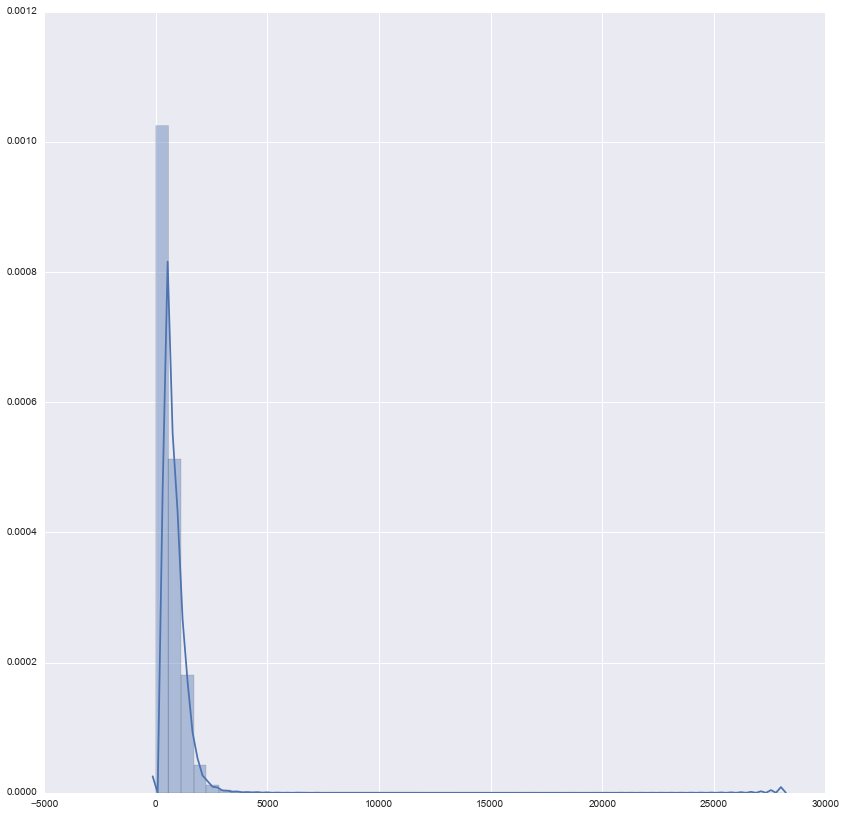

In [123]:
%matplotlib inline   
plt.figure(figsize=(14,14))
sns.set(color_codes=True)
sns.distplot(quals)

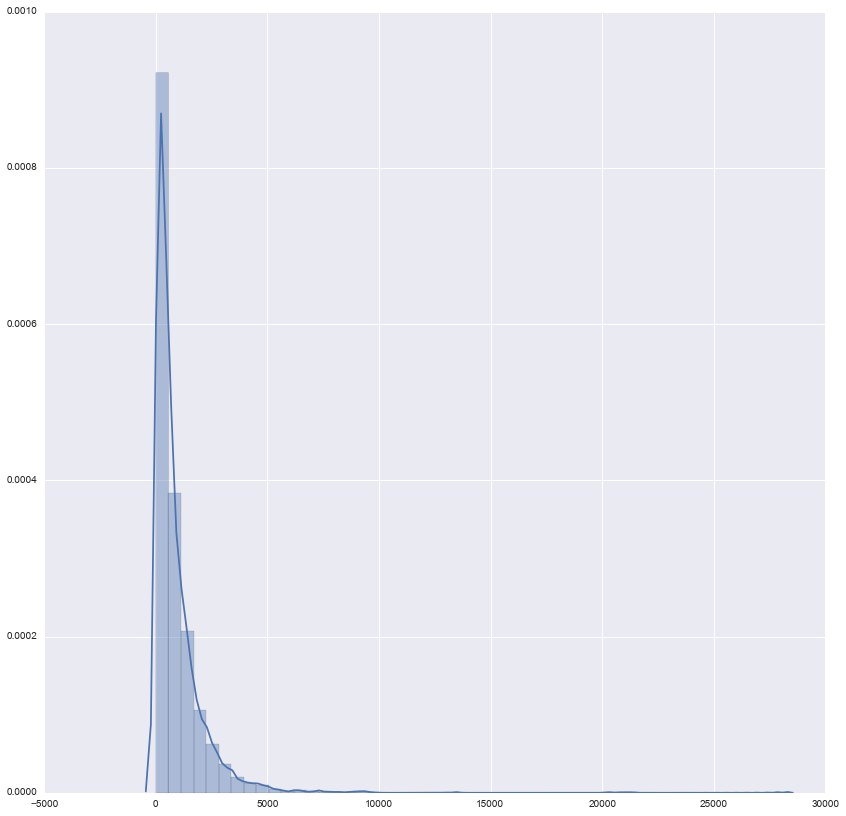

In [124]:
plt.figure(figsize=(14,14))
sns.set(color_codes=True)
sns.distplot(quals_tp)

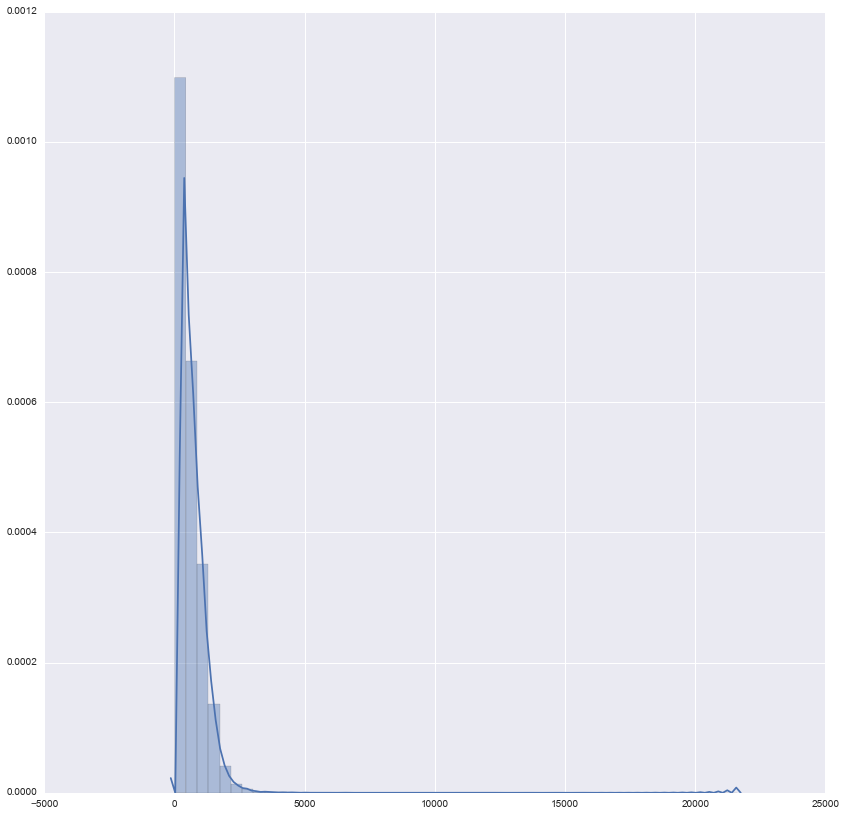

In [125]:
plt.figure(figsize=(14,14))
sns.set(color_codes=True)
sns.distplot(quals_fp)

### 2. Count homopolymers

In [133]:
df_left, df_right = count_homopolymers(reference,our_vcf)
df_left_tp, df_right_tp = count_homopolymers(reference,tp_vcf)
df_left_fp, df_right_fp = count_homopolymers(reference,fp_vcf)

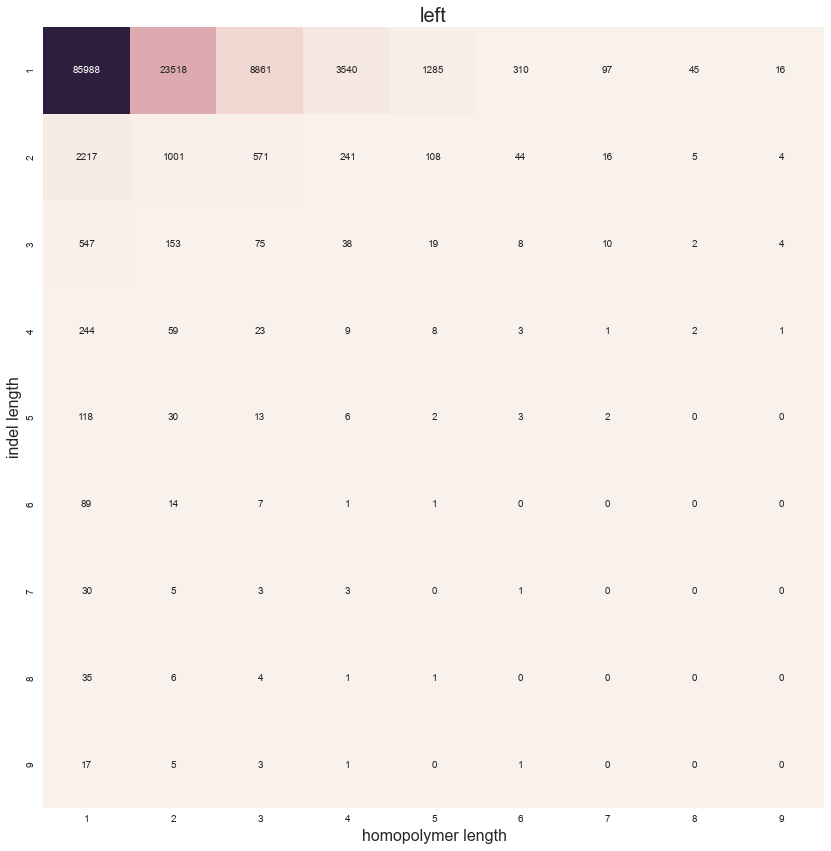

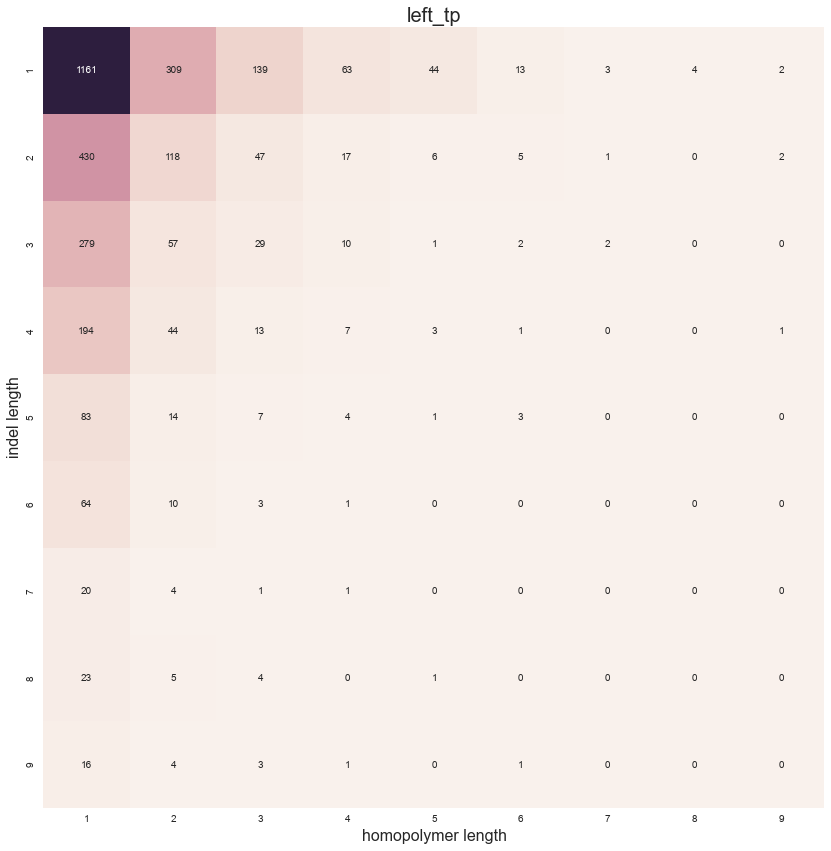

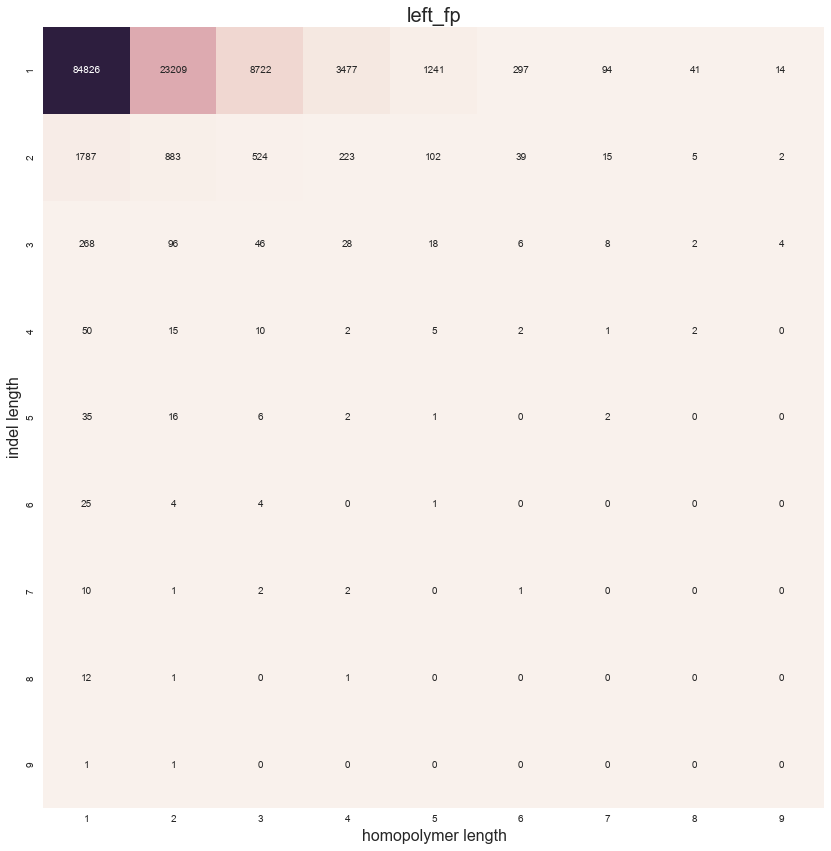

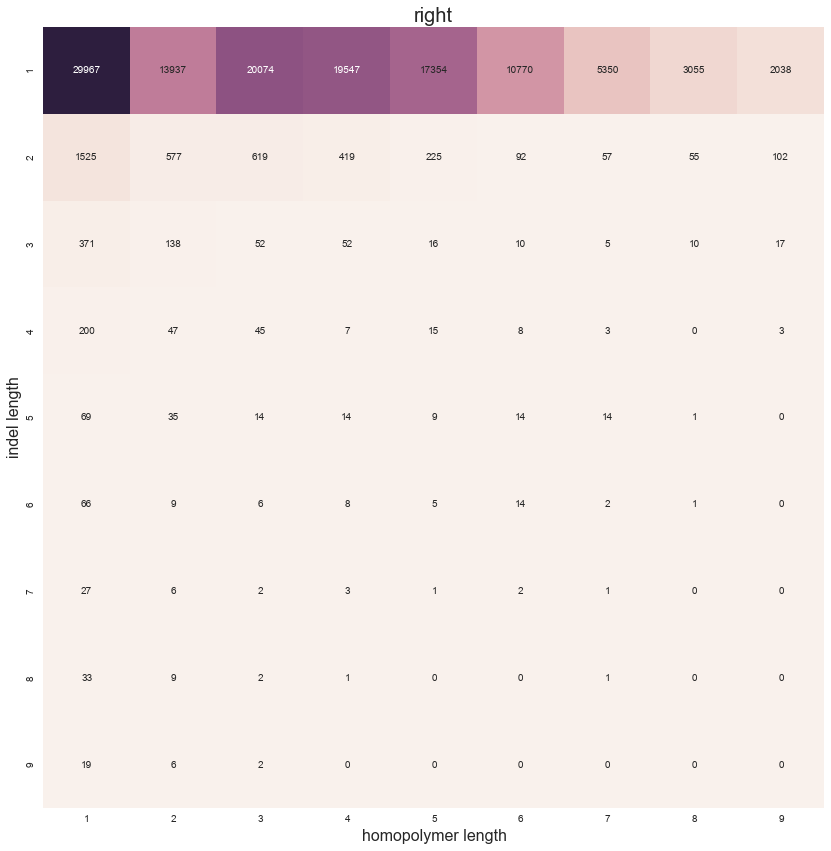

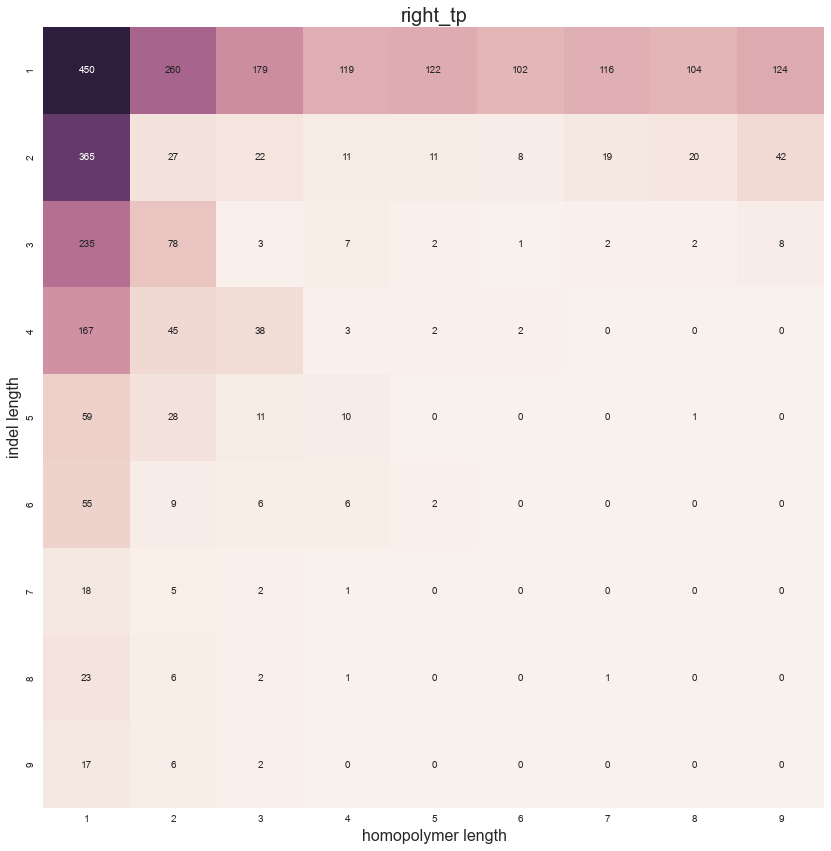

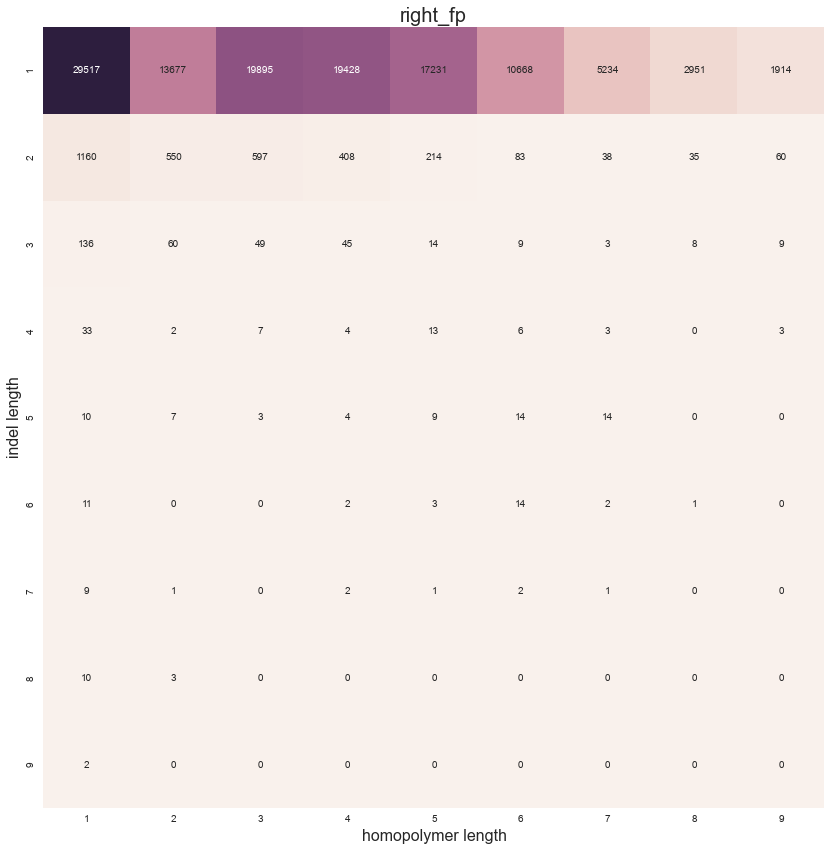

In [189]:
for df,name in [[df_left,'left'],[df_left_tp,'left_tp'],[df_left_fp,'left_fp'],[df_right,'right'],[df_right_tp,'right_tp'],[df_right_fp,'right_fp']]:
    fig = plt.figure(figsize=(14, 14), dpi=500)
    hmap = sns.heatmap(df.as_matrix()[1:10,1:10],cbar = False,annot = True, fmt = 'd',xticklabels = np.arange(9)+1,yticklabels = np.arange(9)+1)
    plt.xlabel('homopolymer length',fontsize=16)
    plt.ylabel('indel length',fontsize=16)
    plt.title(name,fontsize = 20)

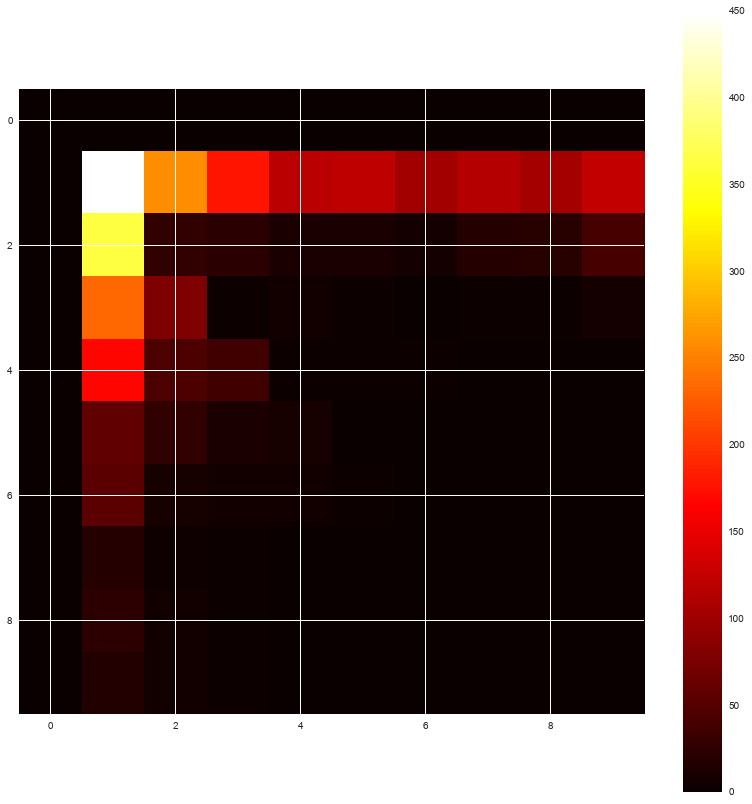

In [130]:
fig = plt.figure(figsize=(14, 14), dpi=500)
plt.imshow(df_right_tp.as_matrix()[:10,:10], cmap='hot', interpolation="nearest")
plt.colorbar()
plt.show()

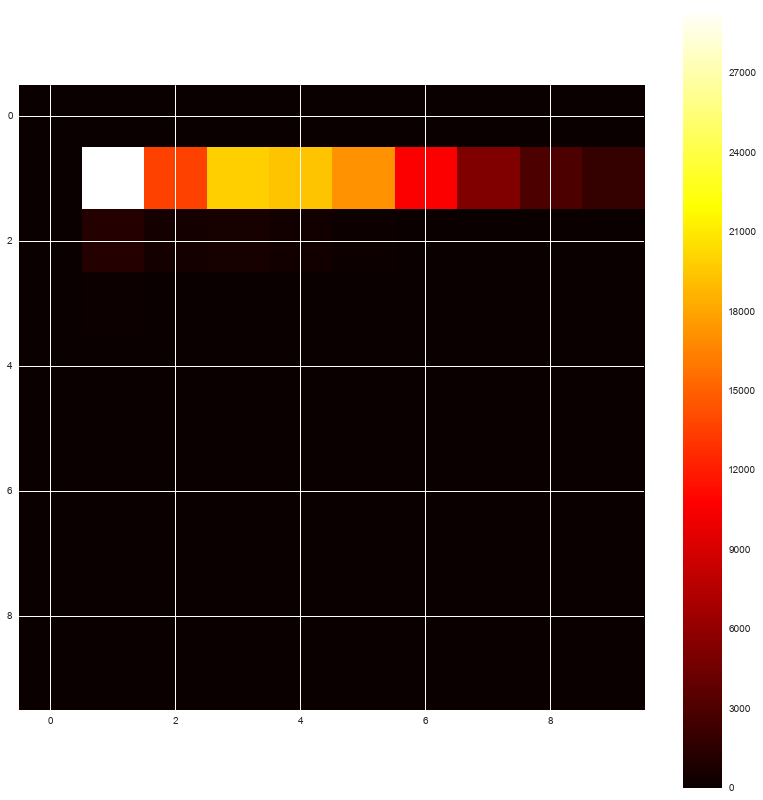

In [118]:
fig = plt.figure(figsize=(14, 14), dpi=500)
plt.imshow(df_right_fp.as_matrix()[:10,:10], cmap='hot', interpolation="nearest")
plt.colorbar()
plt.show()

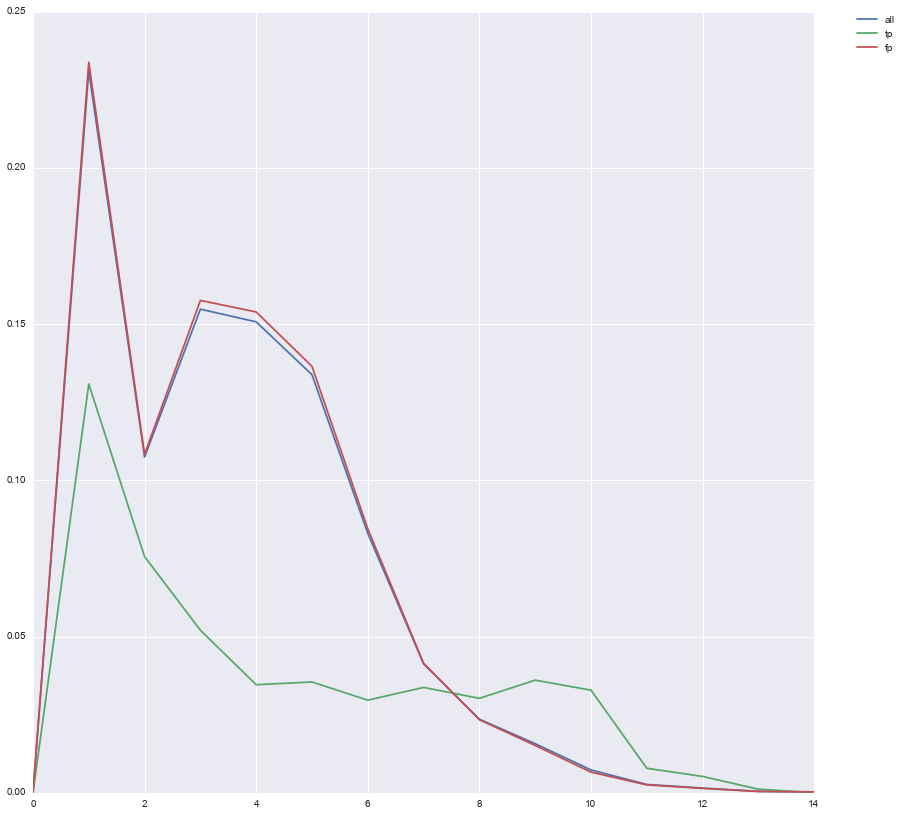

In [102]:
plt.figure(figsize=(14,14))
(df_right/df_right.sum().sum()).T[1][:15].plot(label=u"all")
(df_right_tp/df_right_tp.sum().sum()).T[1][:15].plot(label=u"tp")
(df_right_fp/df_right_fp.sum().sum()).T[1][:15].plot(label=u"fp")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

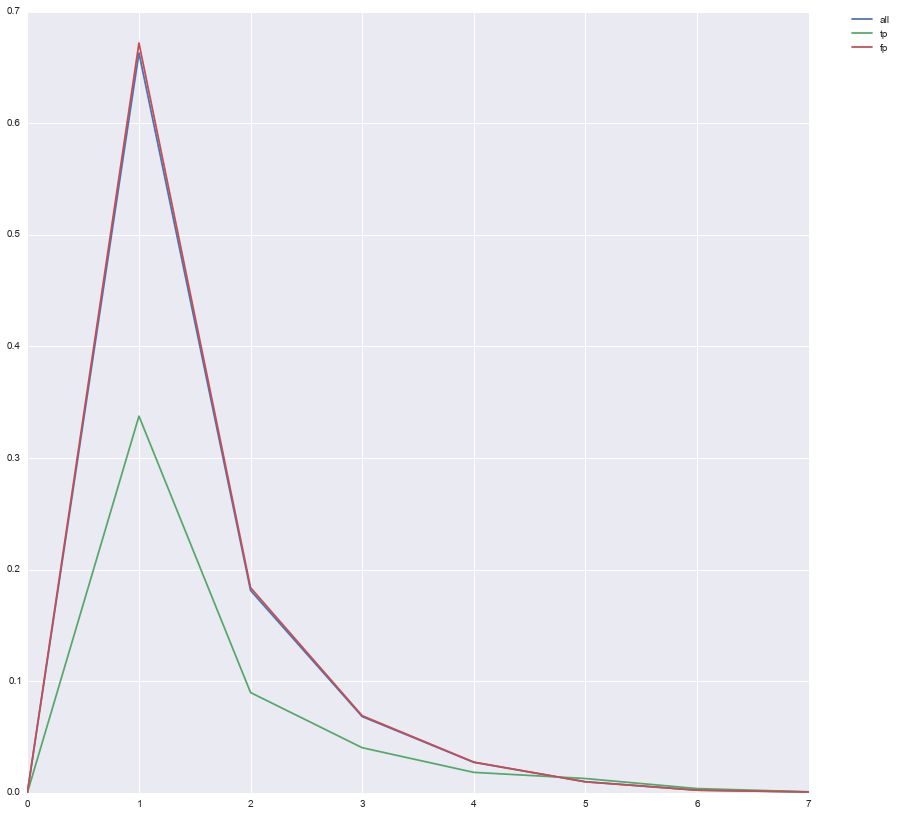

In [103]:
plt.figure(figsize=(14,14))
(df_left/df_left.sum().sum()).T[1][:8].plot(label=u"all")
(df_left_tp/df_left_tp.sum().sum()).T[1][:8].plot(label=u"tp")
(df_left_fp/df_left_fp.sum().sum()).T[1][:8].plot(label=u"fp")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### 3. Count nucleotydes

In [134]:
freq_left, freq_right = count_freq(reference,our_vcf,15)
freq_left_tp, freq_right_tp = count_freq(reference,tp_vcf,15)
freq_left_fp, freq_right_fp = count_freq(reference,fp_vcf,15)

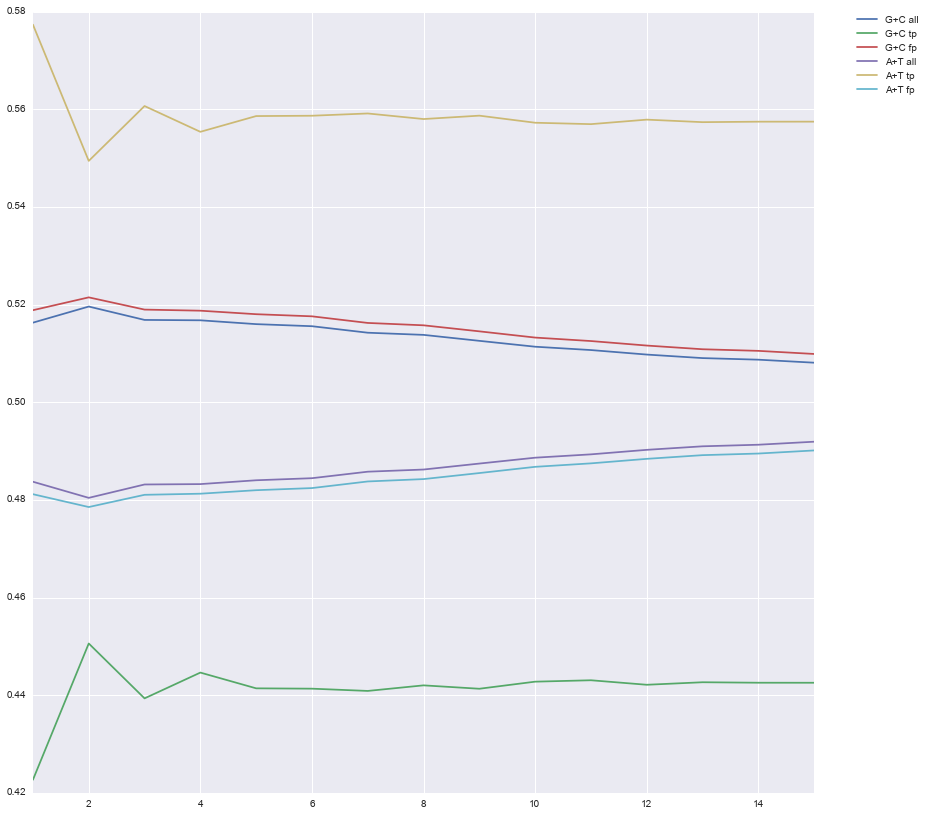

In [115]:
plt.figure(figsize=(14,14))
freq_left['G+C'].plot(label='G+C all')
freq_left_tp['G+C'].plot(label='G+C tp')
freq_left_fp['G+C'].plot(label='G+C fp')
freq_left['A+T'].plot(label='A+T all')
freq_left_tp['A+T'].plot(label='A+T tp')
freq_left_fp['A+T'].plot(label='A+T fp')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

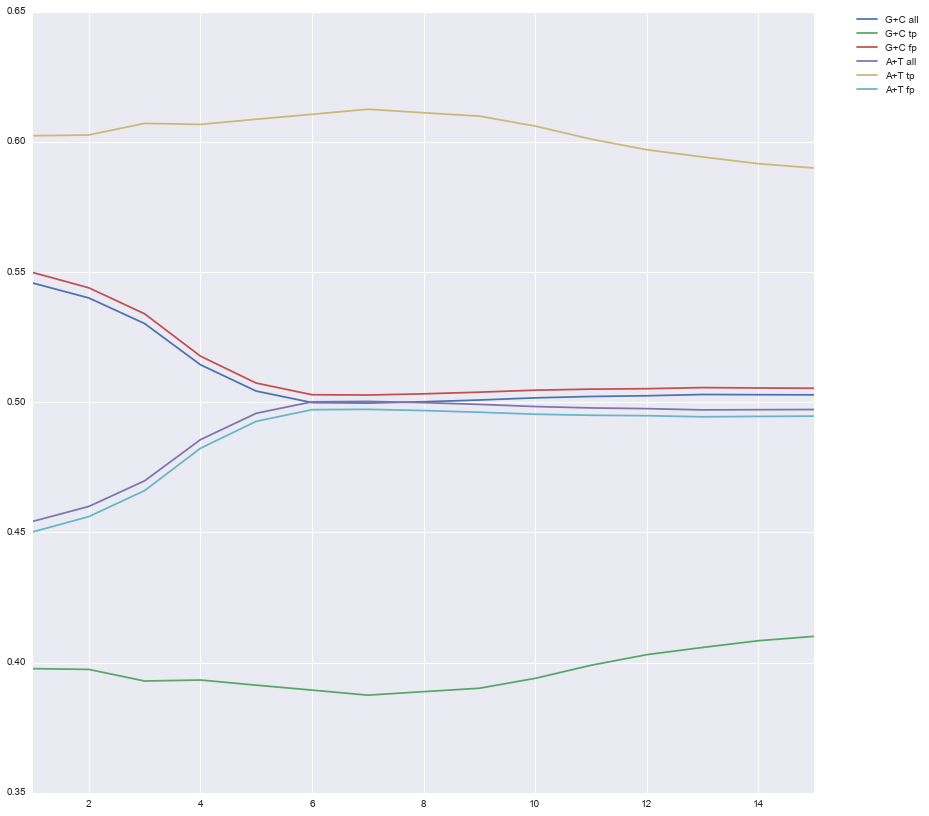

In [117]:
plt.figure(figsize=(14,14))
freq_right['G+C'].plot(label='G+C all')
freq_right_tp['G+C'].plot(label='G+C tp')
freq_right_fp['G+C'].plot(label='G+C fp')
freq_right['A+T'].plot(label='A+T all')
freq_right_tp['A+T'].plot(label='A+T tp')
freq_right_fp['A+T'].plot(label='A+T fp')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
samfile = pysam.AlignmentFile("/home/alexgri/Desktop/indels/GoldenStandard_OurAlgorithms/gcat_set_059-ready.bam", "rb")
#for read in samfile.fetch('1', 1019890, 1019891):
#     print read


for pileupcolumn in samfile.pileup('1', pos, pos+1):
    if (pileupcolumn.pos==pos or pileupcolumn.pos==pos+1 or pileupcolumn.pos==pos-1):
        print ("\ncoverage at base %s = %s" %(pileupcolumn.pos, pileupcolumn.n))
        for pileupread in pileupcolumn.pileups:
            #print pileupread.alignment.seq
            if not pileupread.is_del and not pileupread.is_refskip and (pos-pileupread.alignment.pos>=0) and (pos-pileupread.alignment.pos<len(pileupread.alignment.seq)):
                print ('\tbase in read %s = %s' %(pileupread.alignment.query_name,pileupread.alignment.query_sequence[pos - pileupread.alignment.pos]))
samfile.close()